In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,745 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
pip install layoutparser torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.8 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=4432ae5fe4a6588ad98616d083a5cdf4629e9dfd1ca19a942c21fb37f313b63a
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-4kokkirm/detectron2_cadfb0216b514d069d2bb7dc088bc986
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-

In [ ]:
import layoutparser as lp
import cv2
import matplotlib.pyplot as plt

In [ ]:
image = cv2.imread("test.jpg")
image = image[..., ::-1]
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [ ]:
model = lp.models.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})
    # Load the deep layout model from the layoutparser API
    # For all the supported model, please check the Model
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
layout = model.detect(image)
    # Detect the layout of the input image


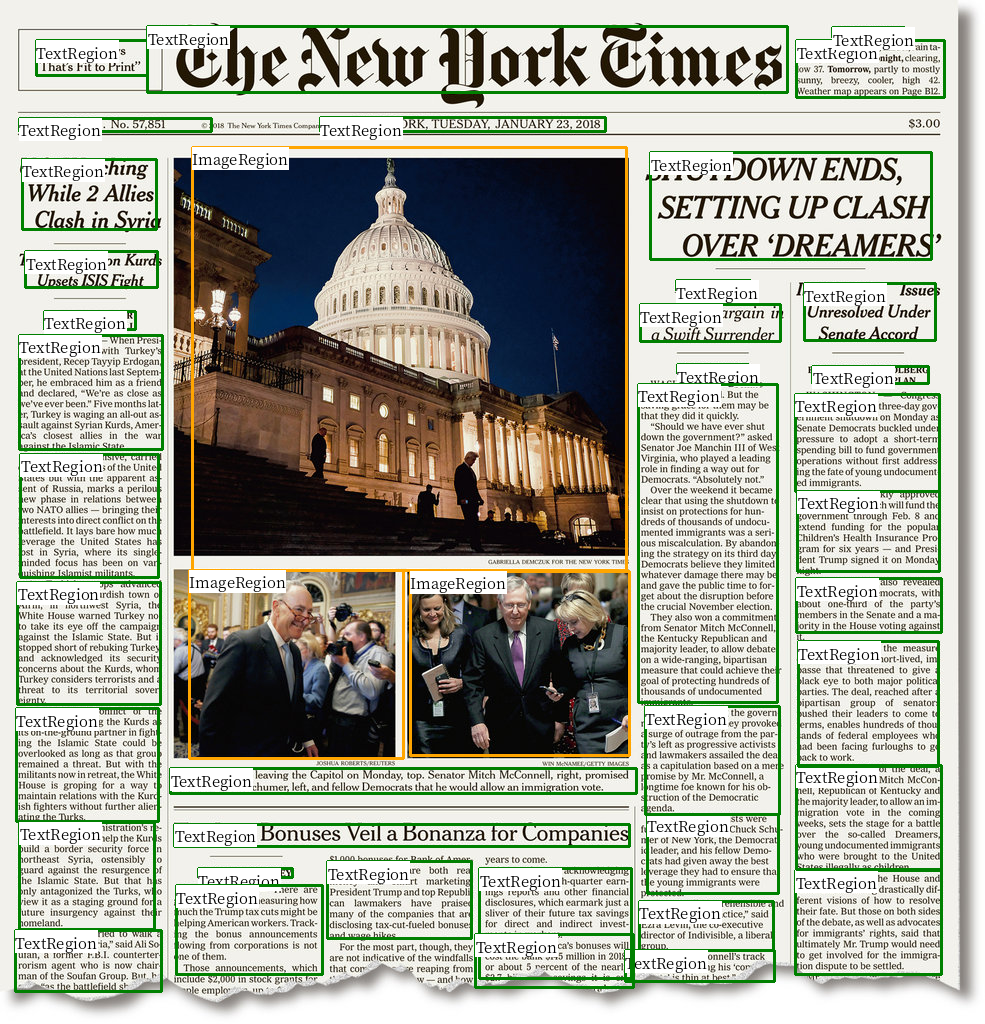

In [ ]:
lp.draw_box(image, layout, box_width=3, color_map={"TextRegion": "green","ImageRegion":"orange"}, show_element_type=True)
    # Show the detected layout of the input image


In [ ]:
type(layout)


layoutparser.elements.layout.Layout

In [ ]:
layout[0]


TextBlock(block=Rectangle(x_1=796.6830444335938, y_1=40.70625686645508, x_2=944.8925170898438, y_2=97.88435363769531), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9999868869781494)

In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=='TextRegion'])
figure_blocks = lp.Layout([b for b in layout if b.type=='ImageRegion'])


In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])


In [ ]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

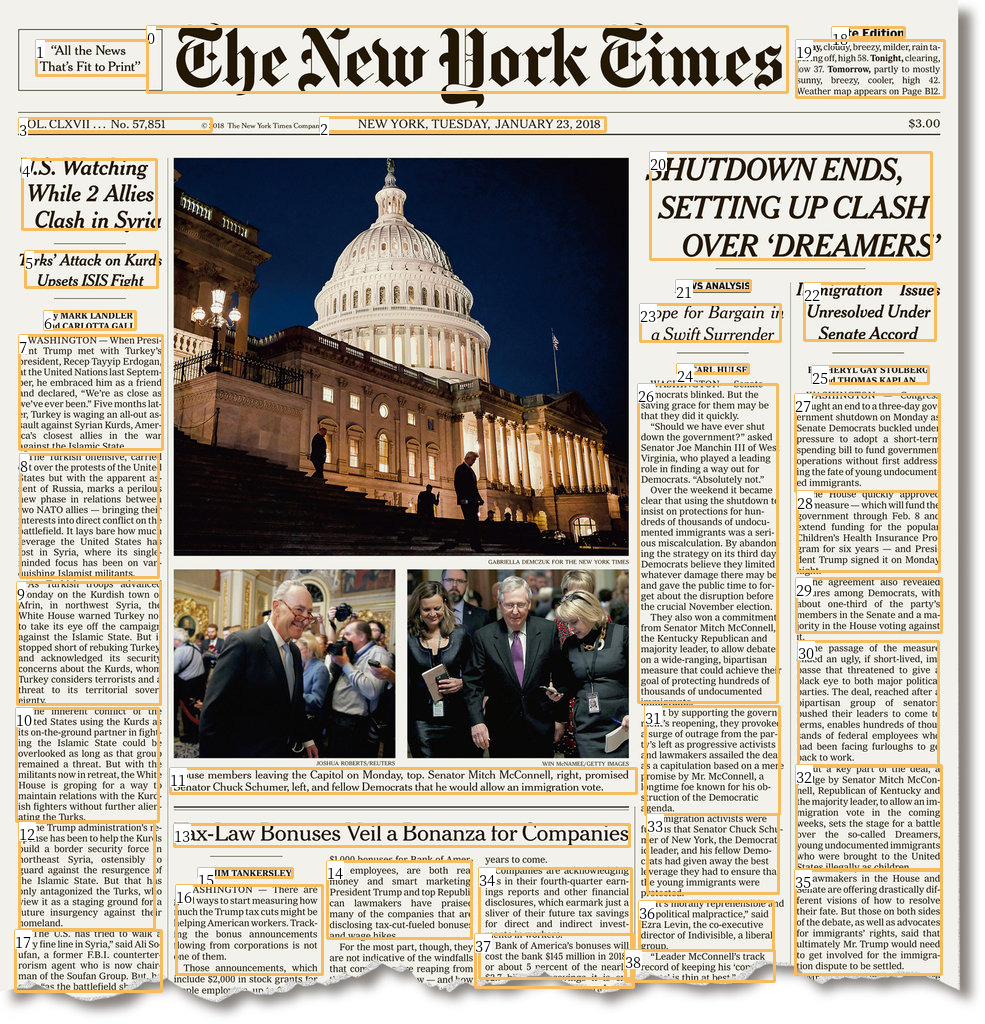

In [ ]:
lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_id=True)

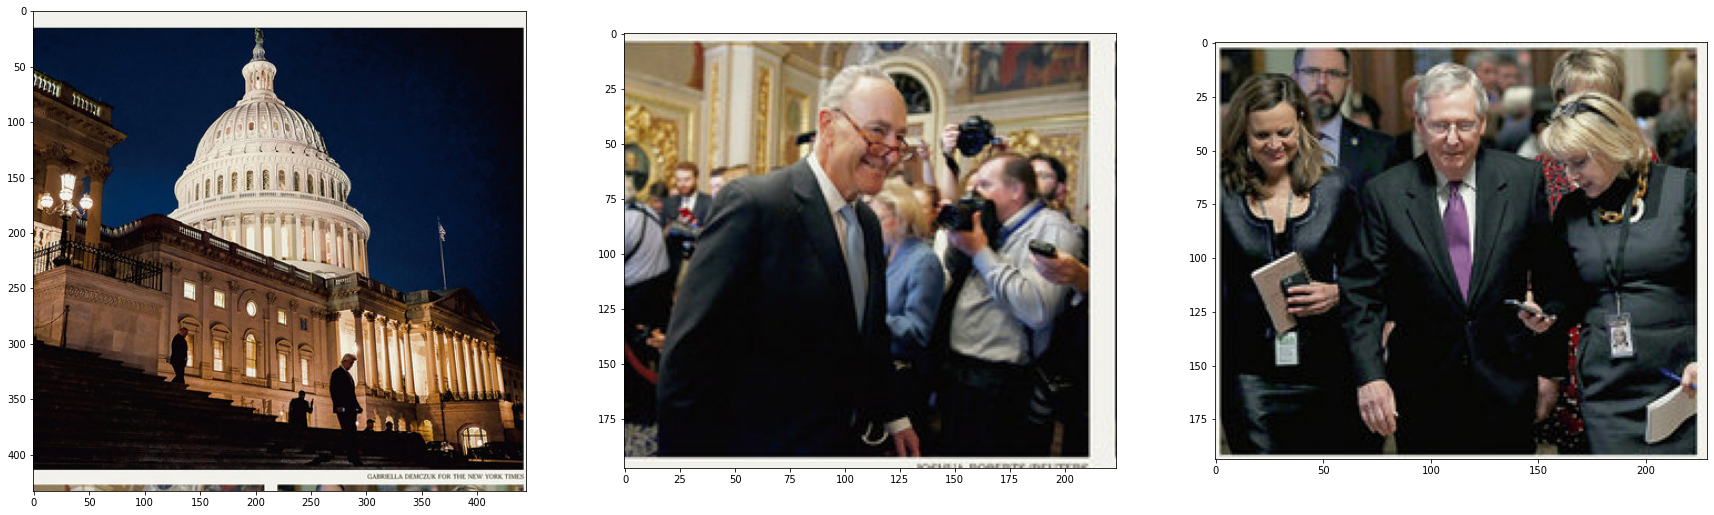

In [ ]:
fig = plt.figure(figsize=(30, 15))
i = 1
for figure in figure_blocks:
    segment_image = (figure
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness
    fig.add_subplot(1, 3, i)
    plt.imshow(segment_image)
    i += 1

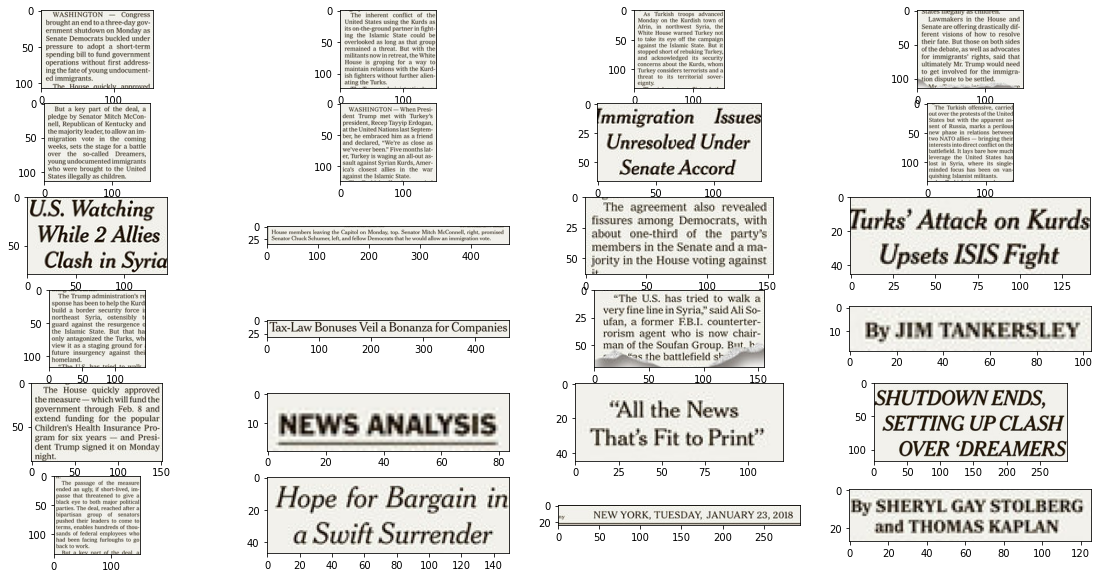

In [ ]:
fig = plt.figure(figsize=(20, 10))
i = 1
for i in range(1, 25):
    segment_image = (text_blocks[i]
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness
    fig.add_subplot(6, 4, i)
    plt.imshow(segment_image)



In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng')
    # Initialize the tesseract ocr engine. You might need
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]



In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for i in range(10):
    print(text_blocks.get_texts()[i], end='\n---\n')

Ehe New ork Eimes

---
“All the News
‘That's Fit to Print”

---
 

NEW YORK, TUESDAY, JANUARY 23, 2018

---
VOL.CLXVII... No. 57,851

 

---
U.S. Watching
While 2 Allies
Clash in Syria

---
Turks’ Attack on Kurds
Upsets ISIS Fight

---
By MARK LANDLER
‘and CARLOTTA GALL

---
WASHINGTON — When Presi-
ent Trump met with Turkey’,
President, Recep Tayyip Erdogan,
tthe Unlied Nations last Septem:
ber ne embraced him asa friend
and declared, “We're as close as
"We've ever been” Five months a
Turkey s waging an all-out as
‘aultagainst Syrian Kurds, mer
fas closest allies in the war
_againat the Islamic State.

---
_ The Turkish offensive, carried

out over the protestsof the United
States but withthe apparent 3s
Sent of Russia, marks a perilous
new phase in'elations between
tivo NATO alles — bringing thei
Interests nto direct conflict on the
Datleied Tt ays bare how much
leverage the United States has
lost in Syria, where its single
minded focus has been on van
quishing Islamist milan